# Rally 2 - Sudoku
### Implementación partiendo del [Tutorial de Peter Norvig](https://norvig.com/sudoku.html).

In [2]:

def cross(A, B):
  "Cross product of elements in A and elements in B."
  return [a+b for a in A for b in B]

digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
# Define lista de unidades como columnas, filas y bloques en ese orden
unitlist = ([cross(rows, c) for c in cols] +
      [cross(r, cols) for r in rows] +
      [cross(rs, cs) for rs in ('CAB','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s])) for s in squares)

In [3]:
def eliminate(values, s, d):
  """Eliminate d from values[s]; propagate when values or places <= 2.
  Return values, except return False if a contradiction is detected."""
  if d not in values[s]:
    return values ## Already eliminated
  values[s] = values[s].replace(d,'')
  ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
  if len(values[s]) == 0:
    return False ## Contradiction: removed last value
  elif len(values[s]) == 1:
    d2 = values[s]
    if not all(eliminate(values, s2, d2) for s2 in peers[s]):
        return False
  ## (2) If a unit u is reduced to only one place for a value d, then put it there.
  for u in units[s]:
    dplaces = [s for s in u if d in values[s]]
    if len(dplaces) == 0:
      return False ## Contradiction: no place for this value
    elif len(dplaces) == 1:
      # d can only be in one place in unit; assign it there
      if not assign(values, dplaces[0], d):
        return False
  return values

def assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

In [4]:
# NOTA: grid hace referencia al grid inicial, values hace referencia al grid que va cambiando mientras se ejecuta el programa
def grid_values(grid):
  "Convert grid into a dict of {square: char} with '0' or '.' for empties."
  chars = [c for c in grid if c in digits or c in '0.']
  assert len(chars) == 81
  return dict(zip(squares, chars))

def parse_grid(grid):
  """Convert grid to a dict of possible values, {square: digits}, or
  return False if a contradiction is detected."""
  ## To start, every square can be any digit; then assign values from the grid.
  values = dict((s, digits) for s in squares)
  for s,d in grid_values(grid).items():
    if d in digits and not assign(values, s, d):
      return False ## (Fail if we can't assign d to square s.)
  return values

In [6]:
def display(values):
  "Display these values as a 2-D grid."
  width = 1+max(len(values[s]) for s in squares)
  line = '+'.join(['-'*(width*3)]*3)
  for r in rows:
    print(''.join(values[r+c].center(width)+('|' if c in '36' else '') for c in cols))
    if r in 'CF':
      print(line)
  print()

In [9]:
def some(seq):
  "Return some element of seq that is true."
  for e in seq:
    if e: 
      return e
  return False

def search(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in squares): 
        return values ## Solved!
    ## Chose the unfilled square s with the fewest possibilities
    n,s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    return some(search(assign(values.copy(), s, d)) 
		for d in values[s])

def solve(grid): 
  return search(parse_grid(grid))

In [28]:
import time

easy  =   "..........4...692.539..2684.24..5.38..38.12..16.2..47.3856..741.163...9.........."
medium =  "7.49..5..5.2.31....3......99.7.1......3.4.2......5.8.13......7....72.9.8..5..43.2"
hard =    "..4.....3....17...75...31......74....9315876....93......93...25...26....1.....4.."
evil =    "....4..5..5...2......91.46.56...3..7..7...3..8..5...46.75.38......1...9..2..5...."
worlds_hardest =  "8..........36......7..9.2...5...7.......457.....1...3...1....68..85...1..9....4.."

def solve_and_measure(sudoku:str, difficulty: str):
  print(f"Solving {difficulty} sudoku...")
  start = time.perf_counter()
  solve(sudoku)
  end = time.perf_counter()
  print(f"Solved {difficulty} sudoku in {end - start}s")

solve_and_measure(easy, "easy")
solve_and_measure(medium, "medium")
solve_and_measure(hard, "hard")
solve_and_measure(evil, "evil")
solve_and_measure(worlds_hardest, "world's hardest")

Solving easy sudoku...
Solved easy sudoku in 0.0023693000002822373s
Solving medium sudoku...
Solved medium sudoku in 0.0021734999972977675s
Solving hard sudoku...
Solved hard sudoku in 0.0025382000021636486s
Solving evil sudoku...
Solved evil sudoku in 0.0026163000002270564s
Solving world's hardest sudoku...
Solved world's hardest sudoku in 0.024885200000426266s


In [29]:
ultimo = """
 .  .  . | .  .  6 | .  .  .
 .  5  9 | .  .  . | .  .  8
 2  .  . | .  .  8 | .  .  .
---------+---------+---------
 .  4  5 | .  .  . | .  .  .
 .  .  3 | .  .  . | .  .  .
 .  .  6 | .  .  3 | .  5  4
---------+---------+---------
 .  .  . | 3  2  5 | .  .  6
 .  .  . | .  .  . | .  .  .
 .  .  . | .  .  . | .  .  .
"""

solve_and_measure(ultimo, "last")

Solving last sudoku...
Solved last sudoku in 30.921394800003327s


## Mejoras potenciales para el algoritmo
Peter Norvig establece 2 reglas a seguir como heurísticas para mejorar su código:  
1. If a square s is reduced to one value d2, then eliminate d2 from the peers.
2. If a unit u is reduced to only one place for a value d, then put it there.  

La regla n. 2 tambien se le llama la regla de "Hidden Singles".  
Hay otras reglas que existen al resolver Sudokus que podemos implementar para mejorar la eficiencia del algoritmo y 2 muy efectivas son Hidden Pairs (3) y Naked Pairs (4).  

Los Hidden Pairs son cuando se tiene el mismo par de 2 dígitos como candidatos en exactamente 2 celdas dentro de la misma unidad. Cuando se presenta este caso, se pueden eliminar los otros candidatos de esas celdas. Esto puede llevar a que se revelen algunos Hidden Singles.  

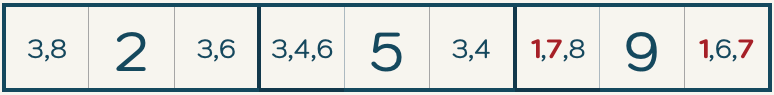  
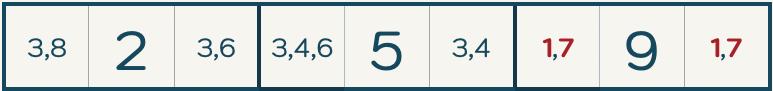  
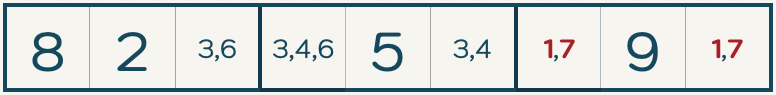  

Otro muy util son los Naked Pairs. Estos son cuando se tiene el mismo par de dígitos como candidatos en exactamente 2 celdas dentro de la misma unidad <b>sin otros candidatos en esas celdas</b>. En ese caso, se pueden eliminar ese par de digitos de todas las otras celdas de su unidad. Esto igual hace que se revelen otros patrones útiles.  

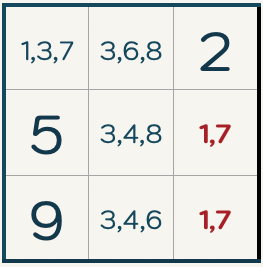   →  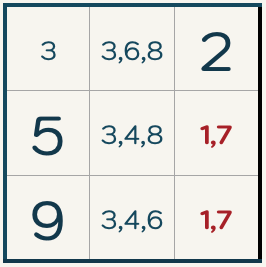   →  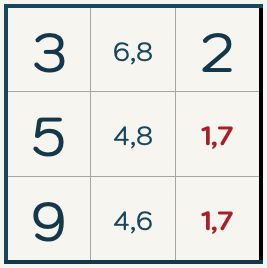

Con estas nuevas reglas se pueden agregar nuevas heurísticas:  
- Si se tiene el mismo par de 2 dígitos como candidatos en exactamente 2 celdas dentro de la misma unidad, elimina los candidatos que no formen parte de ese par en sus celdas.
- Si se tiene el mismo par de 2 dígitos como los únicos candidatos en exactamente 2 celdas dentro de la misma unidad, elimina ese par de dígitos como candidatos de todas las otras celdas en la unidad.